In [1]:
%load_ext autoreload
%autoreload 2
import edhec_risk_kit as erk

ind = erk.get_ind_returns()
er = erk.annualize_rets(ind["1996":"2000"], 12)
cov = ind["1996":"2000"].cov()

In [2]:
from scipy.optimize import minimize
import numpy as np
import pandas as pd
def msr(riskfree_rate, er, cov):
    """
    Riskfree rate + ER + COV -> Weights
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),)*n
    weights_sum_to_1 = {
        'type': 'eq',
        'fun': lambda weights: np.sum(weights) - 1
    }
    
    def neg_sharpe_ratio(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratio, given weights
        """
        r = erk.portfolio_return(weights, er)
        vol = erk.portfolio_vol(weights, cov)
        return -(r - riskfree_rate)/vol
    
    results = minimize(neg_sharpe_ratio, init_guess,
                       args=(riskfree_rate, er, cov,), method="SLSQP",
                       options={'disp': False},
                       constraints=(weights_sum_to_1),
                       bounds=bounds
                      )
    return results.x

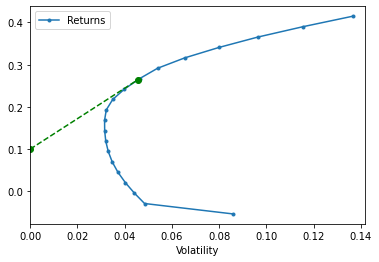

In [3]:
ax = erk.plot_ef(20, er, cov)
ax.set_xlim(left=0)
rf = 0.1
w_msr = msr(rf, er, cov)
r_msr = erk.portfolio_return(w_msr, er)
vol_msr = erk.portfolio_vol(w_msr, cov)
# Add CML
cml_x = [0, vol_msr]
cml_y = [rf, r_msr]
ax.plot(cml_x, cml_y, color="green", marker="o", linestyle="dashed")

(0.0, 0.14178366250985566)

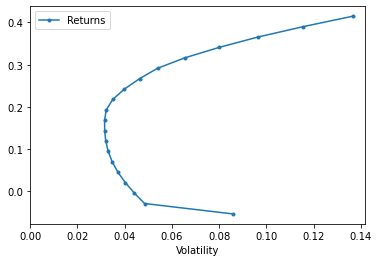

In [30]:
erk.plot_ef(20, er, cov).set_xlim(left=0)

<AxesSubplot:xlabel='Volatility'>

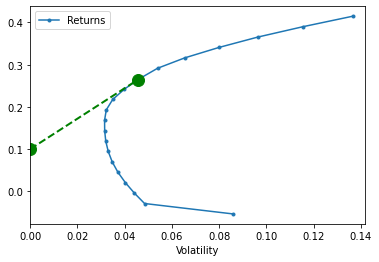

In [14]:
erk.plot_ef(20, er, cov, show_cml=True, riskfree_rate=0.1)

In [15]:
l = ["Food", "Steel"]
erk.msr(0.1, er[l], cov.loc[l,l])

array([0.75040363, 0.24959637])

In [16]:
er[l]

Food     0.116799
Steel    0.115809
dtype: float64

In [17]:
erk.msr(0.1, np.array([0.11, 0.12]), cov.loc[l,l])

array([0.57930354, 0.42069646])

In [19]:
erk.msr(0.1, np.array([0.10, 0.13]), cov.loc[l,l])

array([0., 1.])

In [21]:
erk.msr(0.1, np.array([0.12, 0.11]), cov.loc[l,l])

array([0.85367807, 0.14632193])

<AxesSubplot:xlabel='Volatility'>

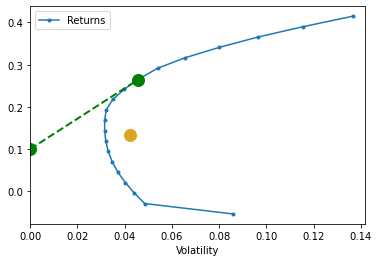

In [22]:
erk.plot_ef(20, er, cov, show_cml=True, riskfree_rate=0.1, show_ew=True)

<AxesSubplot:xlabel='Volatility'>

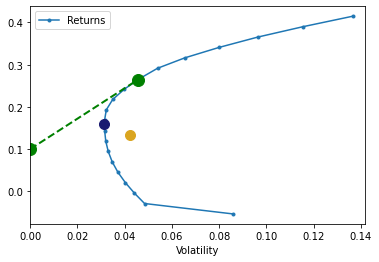

In [23]:
erk.plot_ef(20, er, cov, show_cml=True, riskfree_rate=0.1, show_ew=True,
           show_gmv=True)

과거 수익률 데이터를 이용해 CML을 그리면 정확하게 그릴 수 있지만,   
필드에서 목적은 미래 수익률 예측이기 때문에 과거 수익률 데이터를 그대로 쓰기 어려움.   
게다가 예측 수익률이 조금이라도 달라지면 weights의 변화량이 크게 변하기 때문에,   
maximum Sharpe ratio를 추정해 활용하는건 사실상 불가능.

때문에 모든 자산을 equal weight으로 가져가는 EW portfolio(노란점),  
모든 자산의 RoR을 동일하게 가정하고, maximum sharpe ratio을 구해서 minimum vol을 찾아내는 GMV(파란점)이 실제로 많이 사용됨.